# Intro: modelo de Yard-Sale

In [2]:
import numpy as np
import matplotlib.pyplot as plt

Lo primero que necesitamos es una clase que guarde el modelo base.

In [110]:
class model:
    def __init__(self, n_agentes, w_min=1e-15):
        # Initialize n agents with random risks and wealth between (0, 1] 
        # and normalize wealth
        self.N = n_agentes
        self.w_min = w_min
        # n[i, 0] is the wealth and n[i, 1] is the risk of agent i
        self.n = np.random.rand(self.N, 2)
        # Normalize wealth
        self.n[:, 0] = self.n[:, 0]/(np.sum(self.n[:, 0]))
        self.gini = []
        self.gini.append(self.get_gini())

    def get_opponents(self):
        """Snippet that assigns each agent with another random agent for a 
        pairwise interaction fast and returns an array of opponents
        """
        # Create array of random numbers
        random_array = np.random.randint(0, self.N, self.N)
        # Create array of indices
        self.indices = np.arange(0, self.N)
        # Create array of random numbers that are not equal to the index
        # If i=j then assign j'=i+1 (j'=0 if i=N-1)
        random_array = np.where(random_array == self.indices, 
                                (random_array + 1) % self.N, 
                                random_array)
        
        return random_array
    
    def is_valid(self, i, j):
        # Check if both agents have w > w_min
        if (self.n[i, 0] > self.w_min) and (self.n[j, 0] > self.w_min):
            return True
        else:
            # Set agents with less than w_min to zero
            if self.n[i, 0] < self.w_min:
                self.n[i, 0] = 0
            if self.n[j, 0] < self.w_min:
                self.n[j, 0] = 0
            return False

    def get_dw(self, i, j):
        return np.minimum(self.n[i,0]*self.n[i,1], self.n[j,0]*self.n[j,1])

    def get_gini(self):
        """Computes gini index of a vector w
        """
        total = 0
        w = self.n[:, 0]

        for i, wi in enumerate(w[:-1], 1):
            total += np.sum(np.abs(wi - w[i:]))

        return total / (len(w)**2 * np.mean(w))
        
    
    def update_wealth(self, i, j, dw):
        self.n[i, 0] += dw
        self.n[j, 0] -= dw

    def choose_winner(self, i, j):
        raise Exception('You need to choose a valid model.')

    def MCS(self, steps):
        """
        Main MC loop
        """

        for mcs in range(steps):
            # Choose random j!=i
            j = self.get_opponents()
            
            for i in range(self.N):
                # Check both agents have w > w_min
                if self.is_valid(i, j[i]) is False:
                    continue
                # Compute dw
                dw = self.get_dw(i, j[i])
                # Play the YS game
                winner = self.choose_winner(i, j[i])
                # Change sign of dw if j won
                dw = np.where(winner == i, dw, -dw)
                # Update_wealth
                self.update_wealth(i, j[i], dw)
                
            # After 1 MCS append new Gini index
            self.gini.append(self.get_gini())



Ahora definimos el modelo de Yard-Sale, que hereda del modelo base.

In [111]:
class YSmodel(model):
    def __init__(self, n_agentes, w_min=1e-15, f=0):
        super().__init__(n_agentes, w_min)
        # f is the social protection factor
        self.f = f

    def choose_winner(self, i, j):
        p = .5 + self.f*((self.n[j,0] - self.n[i,0])/
                         (self.n[i,0] + self.n[j,0]))
        # Choose winner, agent i has probability i
        winner = np.random.choice([i, j], p=[p, 1-p])
        
        return winner
        

In [217]:
model = YSmodel(1000, w_min=1e-17, f=.1)

In [218]:
model.MCS(100000)

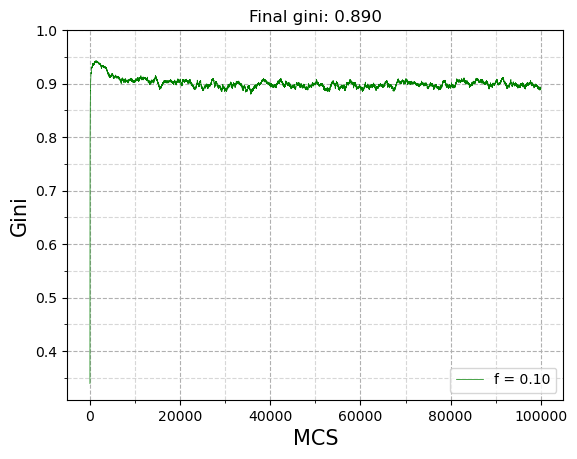

In [228]:
fig, ax = plt.subplots()

ax.plot(model.gini, label='f = {:.2f}'.format(model.f), color='green', linewidth=.5)
ax.set_xlabel('MCS', size=15)
ax.set_ylabel('Gini', size=15)
ax.set_xticks(np.arange(0, 100000, 10000), minor=True)
ax.set_yticks(np.arange(.35, 1.05, .05), minor=True)
ax.legend(loc='lower right')
ax.set_title("Final gini: {:.3f}".format(model.gini[-1]))
ax.grid(which='minor', alpha=.5, linestyle='--')
ax.grid(which='major', alpha=1, linestyle='--')

plt.show()

In [220]:
n_act = np.sum(model.n[:,0]>model.w_min)
w_richest = np.max(model.n[:,0])

print("No. of active agents: {}\nWealth of richest agent: {:.3f}".format(n_act, w_richest))

No. of active agents: 318
Wealth of richest agent: 0.044
